### Intermediate Deliverable 2

- $I=\{DSO545-16278,DSO528-16274,....\}$ Course+Section
- $Im=\{DSO433-16227,DSO516-16305,....\}$ Course+Section that takes place in multiple days of the week
- $J=\{JKP102,JKP104,...\}$ Room
- $K=\{M, T, W, H, F, S, U\}$ Day of the week from Monday to Sunday
- $Ki=$ days of the week that course+section i takes place
- $L=\{0,1,...,14\}$ index of the time slot of each day from 10:00 to 17:00; each time slot is 30 mins.
- Let decision variables be $x_{ijkl}$ to denote whether course+section $i \in I$ assigned to room $j \in J$ on day $k \in K$ at time slot $l \in L$.
- Let $S_{i}$ denote the number of registered students for course+section $i \in I$.
- Let $C_{j}$ denote the capacity of room $j \in J$.
- Let $u_{i}$ denote the total number of slots needed for course+section $i \in I$ for one day. For example, for a 3-hour class, a total of 6 slots is needed; for a 1.5-hour class, a total of 3 slots is needed for a single day.
- Let auxiliary decision variable $U_{ijk}$ corresponding to an upper bound of $x_{ijkl}$'s that belong to the same course+section $i$, room $j$ and day $k$. For example, for course+section $i$, $U_{ijk}$ would be 1 if any of the slots at room $j$ on day $k$ is filled.
- Let $Y_{ik}=\{0,1\}$ denote whether course+section $i$ takes place on day $k$.

$$\begin{aligned}
\text{maximize} && \sum_{i \in I}\sum_{j \in J}\sum_{k \in K}\sum_{l \in L} x_{ijkl}* \frac{S_{i}}{C_{j}}\\\
\text{classroom capacity constraint}&& \ x_{ijkl}*S_{i} \le 0.9*C_{j} & \qquad \text{for all $j \in J$}&\\
\text{day of week constraint}&& \sum_{j \in J}\sum_{l \in L} x_{ijkl} = u_{i}*Y_{ik} & \qquad \text{for all $i \in I$, $k \in K$}&\\
\text{one course constraint}&& \sum_{i \in I} x_{ijkl} \le 1 & \qquad \text{for all $j \in J$, $k \in K$, $l \in L$}&\\
\text{unique room + time slots constraint}&& \sum_{j \in J} x_{ijkl} \le 1 & \qquad \text{for all $i \in I$, $k \in K$, $l \in L$}&\\
\text{}&& \ x_{ijkl} \le U_{ijk} & \qquad \text{for all $i \in I$, $j \in J$, $k \in K$, $l \in L$}&\\
\text{}&& \sum_{l \in L} x_{ijkl} = u_{i}*U_{ijk} & \qquad \text{for all $i \in I$,  $j \in J$, $k \in K$}&\\
\text{consecutive slots constraint}&& \ x_{ijkl} + x_{ijkl'} \le 1 & \qquad \text{for all $i \in I$, $j \in J$, $k \in K$, $l \in L$ except for the last $u_{i}$ $l$s, $l' \ge l+u_{i}-1$} &\\
\text{same slots for multiple-day class constraint}&& \ x_{ijkl} = x_{ij(k+1)l} & \qquad \text{for all $i \in Im$, $j \in J$, $k \in Ki$ except the last k, $l \in L$}&\\
\text{instructor constraint}&& \  & \qquad \text{for all $i \in Im$, $j \in J$, $k \in Ki$ except the last k, $l \in L$}&\\
\end{aligned}$$

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math

file_name = 'full_data'
data = pd.ExcelFile('{}.xlsx'.format(file_name))

courses = data.parse(0, parse_dates=True) #Courses  #pd.read_excel('{}.xlsx'.format(file_name), sheet_name='Course_Enrollment', parse_dates=False)#
courses = courses.set_index(['Course', 'Section'])

rooms = data.parse(1) #Rooms
rooms = rooms.set_index('Room')

rooms_all = data.parse(3) if file_name == 'small_data' else data.parse(1) #All Rooms
rooms_all = rooms_all.set_index('Room')

criteria = 79
courses_small = courses.loc[courses.loc[:,'Reg Count'] < 0.9*criteria,:]
courses_big = courses.loc[courses.loc[:,'Reg Count'] >= 0.9*criteria,:]

rooms_small = rooms.loc[rooms.Size < criteria,:]
rooms_big = rooms.loc[rooms.Size >= criteria,:]

#courses = courses_small
#rooms = rooms_small
#students = data.parse(2) #Students

#AM8:00~PM10:00 total 14 hours, 28 time slots 
#For deliverable 2, we will only use prime time AM10:00~PM5:00 14 slots
slots_per_day = 14 if file_name == 'small_data' else 28
#num_days = 7

I = courses.index #Course name and section (tuple)
J = rooms.index #Room ID
K = ['M', 'T', 'W', 'H', 'F', 'S', 'U']
L = range(0,slots_per_day) #Time slot ID

Ki = courses.loc[:,'First Days']

s = courses.loc[:,'Reg Count'] #Registration Count
c = rooms.Size #Room Capacity

def ChangeTypeUID(item):
    try:
        return str(int(item))
    except:
        return ''

UIDs = courses.loc[:,'First Instructor UID'].apply(ChangeTypeUID)

#Convert time difference to 30 mins unit slot: 3 h = 6 slots, 1 h 20 m = 3 slots
u2 = pd.to_datetime(courses.loc[:,'First End Time'].astype(str))#.apply(datetime)
u1 = pd.to_datetime(courses.loc[:,'First Begin Time'].astype(str))
u = ((u2-u1).apply(timedelta.total_seconds)/1800).apply(math.ceil).astype(int)

utilization_rate = sum([float(u[i]*len(Ki[i])*s[i])/float(rooms_all.Size[courses.loc[:,'First Room'][i]]) \
                        if courses.loc[:,'First Room'][i] in rooms_all.index else 0.6 for i in I])#/float(sum([u[i]*len(Ki[i]) for i in I]))
print('Utilization before optimization:', utilization_rate)
#149/float(sum([u[i]*len(Ki[i]) for i in I]))

courses.describe()

('Utilization before optimization:', 2484.2862233425994)


,First Instructor UID,Max Units,Min Units,Reg Count,Seats,Second Instructor UID,Session,Term
count,5.250000e+02,528.000000,528.000000,528.000000,528.000000,5.000000e+01,528.000000,528.0
mean,5.757748e+09,2.829545,2.829545,41.905303,50.469697,5.693009e+09,73.352273,20171.0
std,2.742344e+09,1.413314,1.413314,26.314521,28.020781,3.035105e+09,185.140013,0.0
min,1.037008e+09,0.000000,0.000000,4.000000,10.000000,1.181506e+09,1.000000,20171.0
25%,3.439925e+09,2.000000,2.000000,28.000000,36.000000,2.849420e+09,1.000000,20171.0
50%,5.811108e+09,3.000000,3.000000,37.000000,47.000000,5.538650e+09,1.000000,20171.0
75%,8.285354e+09,4.000000,4.000000,48.000000,56.000000,8.495512e+09,33.000000,20171.0
max,9.994127e+09,10.000000,10.000000,258.000000,265.000000,9.952102e+09,894.000000,20171.0


In [22]:
import gurobipy as grb
mod=grb.Model()

# Set Parameters for large model
#mod.Params.timelimit = 3600.0*3
mod.Params.solutionlimit = 2
#mod.Params.MIPFocus = 1

#mod.getParamInfo('*')

Changed value of parameter solutionlimit to 2
   Prev: 2000000000  Min: 1  Max: 2000000000  Default: 2000000000


In [23]:
#Variable Definition
x={} #binary variable whether the course is assigned to each room at each time slot of each day
U={} #Maximum value of all slots for that day for each course and each room
for i in I:
    for j in J:
        for k in K:
            U[i,j,k]=mod.addVar(vtype=grb.GRB.BINARY, name='U[{0},{1},{2}]'.format(i,j,k)) #vtype=grb.GRB.BINARY,
            for l in L:
                x[i,j,k,l]=mod.addVar(vtype=grb.GRB.BINARY,name='x[{0},{1},{2},{3}]'.format(i,j,k,l))
print('Variable Definition')

#Classroom capacity constraint
numConstr = 0
for i in I:
    for j in J:
        for k in Ki[i][:1]:
            for l in L:
                mod.addConstr(x[i,j,k,l]*s[i] <= c[j])
                numConstr += 1
                
print('Classroom capacity constraint: {}'.format(numConstr))

#Day of week constraint
numConstr = 0
for i in I:
    for k in K:
        if k not in Ki[i]:
            mod.addConstr(grb.quicksum(x[i,j,k,l] for j in J for l in L)==0)
            numConstr += 1
        else:
            mod.addConstr(grb.quicksum(x[i,j,k,l] for j in J for l in L)==u[i])
            numConstr += 1
print('Day of week constraint: {}'.format(numConstr))

#One course constraint
numConstr = 0
for j in J:
    for k in K:
        for l in L:
            mod.addConstr(grb.quicksum(x[i,j,k,l] for i in I) <= 1)
            numConstr += 1
print('One course constraint: {}'.format(numConstr))

#Unique room constraint
#for i in I:
#    for k in K:
#        for l in L:
#            mod.addConstr(sum(x[i,j,k,l] for j in J) <= 1)
numConstr = 0
for i in I:
    for j in J:
        for k in Ki[i]:
            for l in L:
                mod.addConstr(x[i,j,k,l] <= U[i,j,k])
                numConstr += 1
            mod.addConstr(grb.quicksum(x[i,j,k,l] for l in L) == u[i]*U[i,j,k])
            numConstr += 1
print('Unique room constraint: {}'.format(numConstr))

#Consecutive constraint
numConstr = 0
for i in I:
    for j in J:
        for k in Ki[i][:1]:
            #for l in L:
            #    if l + u[i]-1 < len(L) - 1:
            #        for m in range(l + u[i], len(L)):
            #            mod.addConstr(x[i,j,k,l] + x[i,j,k,m] <= 1)
            #            numConstr += 1
            for m in range(slots_per_day):
                for n in range(u[i], slots_per_day-m):
                    divider = True
                    if m-n>=0 :
                        divider = False
                    for o in range(u[i],n):
                        if n%o==0:
                            divider = False
                    if divider:
                        L_1 = range(m,len(L))
                        L_2 = [True if (l-m)%n == 0 else False for l in L_1 ]
                        mod.addConstr(grb.quicksum(x[i,j,k,l] for l in np.array(L_1)[L_2] ) <= 1)
                        numConstr += 1
#            for m in range(u[i]):
#                L_ = [True if (l-m)%u[i] == 0 else False for l in L ]
#                mod.addConstr(grb.quicksum(x[i,j,k,l] for l in np.array(L)[L_] ) <= 1)
#                numConstr += 1

print('Consecutive constraint: {}'.format(numConstr))

#Same instuctor constraint
numConstr = 0
for k in K:
    for l in L:
        for uid in np.unique(UIDs.values[UIDs.values!='']):
            I_uid_boolean = (UIDs == uid)
            I_uid = I.values[I_uid_boolean]
            I_uid_day_boolean = [True if k in Ki[i] else False for i in I_uid]
            I_uid_day = I_uid[I_uid_day_boolean]
            if sum(I_uid_day_boolean) > 1:
                mod.addConstr(grb.quicksum(x[i,j,k,l] for i in I_uid_day for j in J) <= 1)
                numConstr += 1
print('Same instuctor constraint: {}'.format(numConstr))

#Same slot of day constraint for multiple days
numConstr = 0
for i in I:
    if len(Ki[i]) > 1:
        for j in J:
            for index, k in enumerate(Ki[i]):
                if index < len(Ki[i])-1:
                    for l in L:
                        mod.addConstr(x[i,j,Ki[i][index],l]==x[i,j,Ki[i][index+1],l])
                        numConstr += 1
print('Same slot of day constraint for multiple days: {}'.format(numConstr))

#Objective function
mod.setObjective(sum(x[i,j,k,l]*s[i]/c[j] for i in I for j in J for k in K for l in L) , sense=grb.GRB.MAXIMIZE)

#Optimize
mod.optimize()
print('Optimal Objective:', mod.ObjVal)

Variable Definition
Classroom capacity constraint: 680064
Day of week constraint: 3696
One course constraint: 9016
Unique room constraint: 1163248
Consecutive constraint: 1944834
Same instuctor constraint: 7476
Same slot of day constraint for multiple days: 443072
Optimize a model with 4251406 rows, 4930464 columns and 21257980 nonzeros
Variable types: 0 continuous, 4930464 integer (4930464 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 957684 rows and 407524 columns (presolve time = 5s) ...
Presolve removed 2190159 rows and 4452605 columns (presolve time = 10s) ...
Presolve removed 2190159 rows and 4452605 columns (presolve time = 22s) ...
Presolve removed 2190159 rows and 4452605 columns (presolve time = 30s) ...
Presolve removed 2190159 rows and 4452605 columns (presolve time = 38s) ...
Presolve removed 2190159 rows and 4452605 columns (presolve t

   22452 PPushes remaining with PInf 0.0000000e+00               728s
   21679 PPushes remaining with PInf 0.0000000e+00               733s
   20387 PPushes remaining with PInf 0.0000000e+00               739s
   19740 PPushes remaining with PInf 0.0000000e+00               743s
   19010 PPushes remaining with PInf 0.0000000e+00               747s
   18452 PPushes remaining with PInf 0.0000000e+00               752s
   17934 PPushes remaining with PInf 0.0000000e+00               756s
   17366 PPushes remaining with PInf 0.0000000e+00               760s
   16336 PPushes remaining with PInf 0.0000000e+00               768s
   15849 PPushes remaining with PInf 0.0000000e+00               772s
   15364 PPushes remaining with PInf 0.0000000e+00               778s
   14870 PPushes remaining with PInf 0.0000000e+00               783s
   13905 PPushes remaining with PInf 0.0000000e+00               790s
   13318 PPushes remaining with PInf 0.0000000e+00               794s
   12792 PPushes rem

  592506    2.9790734e+03   1.496609e+05   0.000000e+00   1784s
  592990    2.9790734e+03   1.216963e+05   0.000000e+00   1871s
  593474    2.9790734e+03   1.883900e+05   0.000000e+00   1957s
  593958    2.9790734e+03   9.914989e+04   0.000000e+00   2051s
  594442    2.9790734e+03   1.757906e+05   0.000000e+00   2135s
  594926    2.9790734e+03   1.324953e+05   0.000000e+00   2217s
  595410    2.9790734e+03   3.308175e+04   0.000000e+00   2309s
  595894    2.9790734e+03   9.869428e+04   0.000000e+00   2404s
  596378    2.9790734e+03   7.236055e+04   0.000000e+00   2495s
  596862    2.9790734e+03   1.545639e+05   0.000000e+00   2588s
  597346    2.9790733e+03   3.107645e+05   0.000000e+00   2674s
  597830    2.9790733e+03   2.099663e+05   0.000000e+00   2758s
  598314    2.9790733e+03   6.949881e+04   0.000000e+00   2837s
  598798    2.9790733e+03   1.470398e+05   0.000000e+00   2918s
  599282    2.9790733e+03   9.054801e+04   0.000000e+00   3004s
  599766    2.9790733e+03   2.280153e+05

  654942    2.9790715e+03   9.170813e+05   0.000000e+00  11264s
  655426    2.9790715e+03   1.235687e+06   0.000000e+00  11336s
  655910    2.9790715e+03   2.283514e+06   0.000000e+00  11409s
  656394    2.9790715e+03   1.902206e+06   0.000000e+00  11487s
  656878    2.9790715e+03   3.687621e+05   0.000000e+00  11558s
  657362    2.9790715e+03   1.895391e+05   0.000000e+00  11634s
  657846    2.9790715e+03   8.937262e+05   0.000000e+00  11712s
  658330    2.9790714e+03   2.698076e+05   0.000000e+00  11777s
  658814    2.9790714e+03   2.071194e+06   0.000000e+00  11836s
  659298    2.9790713e+03   1.395523e+06   0.000000e+00  11900s
  659782    2.9790713e+03   1.747728e+06   0.000000e+00  11965s
  660266    2.9790713e+03   1.131114e+06   0.000000e+00  12032s
  660750    2.9790713e+03   8.963619e+05   0.000000e+00  12096s
  661234    2.9790713e+03   9.589151e+05   0.000000e+00  12165s
  661718    2.9790712e+03   3.305083e+06   0.000000e+00  12229s
  662202    2.9790712e+03   2.325069e+06

  717378    2.9790699e+03   1.742824e+06   0.000000e+00  20628s
  717862    2.9790699e+03   6.581000e+05   0.000000e+00  20698s
  718346    2.9790699e+03   1.051491e+06   0.000000e+00  20769s
  718830    2.9790699e+03   6.438392e+06   0.000000e+00  20848s
  719314    2.9790699e+03   4.899290e+06   0.000000e+00  20924s
  719798    2.9790698e+03   4.646437e+05   0.000000e+00  20999s
  720282    2.9790698e+03   4.400046e+05   0.000000e+00  21076s
  720766    2.9790698e+03   2.187819e+05   0.000000e+00  21145s
  721250    2.9790698e+03   7.442506e+05   0.000000e+00  21217s
  721734    2.9790698e+03   3.326697e+05   0.000000e+00  21288s
  722218    2.9790697e+03   5.701027e+05   0.000000e+00  21367s
  722702    2.9790697e+03   3.940321e+05   0.000000e+00  21438s
  723186    2.9790697e+03   1.314325e+06   0.000000e+00  21514s
  723670    2.9790697e+03   3.892370e+06   0.000000e+00  21589s
  724154    2.9790697e+03   2.746154e+05   0.000000e+00  21666s
  724638    2.9790697e+03   4.369527e+06

  779814    2.9790687e+03   1.431357e+06   0.000000e+00  30223s
  780298    2.9790687e+03   2.690586e+05   0.000000e+00  30296s
  780782    2.9790687e+03   2.980267e+05   0.000000e+00  30374s
  781266    2.9790686e+03   1.456514e+06   0.000000e+00  30448s
  781750    2.9790686e+03   2.537397e+05   0.000000e+00  30531s
  782234    2.9790686e+03   5.712102e+05   0.000000e+00  30613s
  782718    2.9790686e+03   3.491706e+05   0.000000e+00  30690s
  783202    2.9790686e+03   6.257220e+05   0.000000e+00  30770s
  783686    2.9790686e+03   3.973928e+05   0.000000e+00  30846s
  784170    2.9790686e+03   3.166038e+05   0.000000e+00  30920s
  784654    2.9790686e+03   1.115492e+07   0.000000e+00  31000s
  785138    2.9790686e+03   4.164810e+05   0.000000e+00  31073s
  785622    2.9790686e+03   1.270802e+06   0.000000e+00  31152s
  786106    2.9790686e+03   1.197852e+06   0.000000e+00  31230s
  786590    2.9790686e+03   6.748962e+05   0.000000e+00  31301s
  787074    2.9790686e+03   1.061230e+06

  842250    2.9790676e+03   7.896222e+05   0.000000e+00  40052s
  842734    2.9790676e+03   2.072499e+06   0.000000e+00  40122s
  843218    2.9790676e+03   7.989074e+05   0.000000e+00  40194s
  843702    2.9790676e+03   8.243008e+05   0.000000e+00  40267s
  844186    2.9790676e+03   1.357844e+06   0.000000e+00  40340s
  844670    2.9790676e+03   2.547522e+05   0.000000e+00  40416s
  845154    2.9790676e+03   3.463040e+05   0.000000e+00  40496s
  845638    2.9790676e+03   7.601633e+04   0.000000e+00  40572s
  846122    2.9790676e+03   1.436249e+05   0.000000e+00  40646s
  846606    2.9790676e+03   5.678655e+04   0.000000e+00  40729s
  847090    2.9790676e+03   5.774524e+06   0.000000e+00  40805s
  847574    2.9790676e+03   1.647047e+06   0.000000e+00  40883s
  848058    2.9790675e+03   2.855094e+05   0.000000e+00  40954s
  848542    2.9790675e+03   1.145592e+06   0.000000e+00  41031s
  849026    2.9790675e+03   1.253891e+05   0.000000e+00  41101s
  849510    2.9790675e+03   8.812541e+05

  904686    2.9790670e+03   1.498696e+05   0.000000e+00  50244s
  905170    2.9790670e+03   8.886823e+05   0.000000e+00  51754s
  905654    2.9790670e+03   3.195653e+05   0.000000e+00  51841s
  906138    2.9790670e+03   2.132485e+05   0.000000e+00  51944s
  906622    2.9790670e+03   8.133453e+06   0.000000e+00  52055s
  907106    2.9790670e+03   1.442546e+06   0.000000e+00  52168s
  907590    2.9790670e+03   1.673616e+05   0.000000e+00  52274s
  908074    2.9790670e+03   5.889017e+06   0.000000e+00  52381s
  908558    2.9790670e+03   6.280255e+05   0.000000e+00  52497s
  909042    2.9790670e+03   1.677264e+05   0.000000e+00  52602s
  909526    2.9790669e+03   4.497465e+05   0.000000e+00  52707s
  910010    2.9790669e+03   1.444025e+05   0.000000e+00  52823s
  910494    2.9790669e+03   1.498930e+05   0.000000e+00  52921s
  910978    2.9790669e+03   1.433073e+06   0.000000e+00  53031s
  911462    2.9790669e+03   2.199389e+05   0.000000e+00  53141s
  911946    2.9790669e+03   1.890018e+05

  967122    2.9790664e+03   1.806864e+05   0.000000e+00  63789s
  967606    2.9790664e+03   7.476198e+04   0.000000e+00  63882s
  968090    2.9790664e+03   1.646491e+05   0.000000e+00  63990s
  968574    2.9790664e+03   2.113941e+05   0.000000e+00  64094s
  969058    2.9790664e+03   6.397217e+05   0.000000e+00  64204s
  969542    2.9790664e+03   1.576121e+05   0.000000e+00  64312s
  970026    2.9790664e+03   8.541420e+04   0.000000e+00  64407s
  970510    2.9790664e+03   4.007838e+04   0.000000e+00  64508s
  970994    2.9790664e+03   4.905609e+05   0.000000e+00  64624s
  971478    2.9790664e+03   8.266731e+04   0.000000e+00  64754s
  971962    2.9790664e+03   6.424715e+04   0.000000e+00  64856s
  972446    2.9790664e+03   3.313056e+05   0.000000e+00  64976s
  972930    2.9790664e+03   4.962319e+05   0.000000e+00  65085s
  973414    2.9790664e+03   1.708037e+05   0.000000e+00  65194s
  973898    2.9790663e+03   4.396475e+05   0.000000e+00  65304s
  974382    2.9790663e+03   9.705480e+05

 1029558    2.9790660e+03   1.559937e+05   0.000000e+00  78165s
 1030042    2.9790660e+03   6.758786e+04   0.000000e+00  78249s
 1030526    2.9790660e+03   1.779132e+04   0.000000e+00  78315s
 1031010    2.9790660e+03   4.958657e+03   0.000000e+00  78396s
 1031494    2.9790660e+03   2.436167e+04   0.000000e+00  78473s
 1031978    2.9790660e+03   2.379689e+04   0.000000e+00  78551s
 1032462    2.9790660e+03   8.791641e+03   0.000000e+00  78633s
 1032946    2.9790660e+03   1.144346e+05   0.000000e+00  78709s
 1033430    2.9790660e+03   6.562501e+03   0.000000e+00  78793s
 1033914    2.9790660e+03   7.276560e+04   0.000000e+00  78880s
 1034398    2.9790660e+03   1.665544e+05   0.000000e+00  78958s
 1034882    2.9790660e+03   9.354665e+04   0.000000e+00  79034s
 1035366    2.9790660e+03   6.515346e+03   0.000000e+00  79114s
 1035850    2.9790660e+03   1.328271e+04   0.000000e+00  79188s
 1036334    2.9790660e+03   1.879465e+04   0.000000e+00  79265s
 1036818    2.9790660e+03   6.086254e+04


Solved with barrier

Root relaxation: objective 2.979073e+03, 1090021 iterations, 88332.79 seconds
Total elapsed time = 100705.09s
Total elapsed time = 104809.15s
Total elapsed time = 108142.42s
Total elapsed time = 109538.88s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2979.07336    0 2871          - 2979.07336      -     - 110576s
     0     0 2979.07336    0 5471          - 2979.07336      -     - 117854s
     0     0 2979.07336    0 5198          - 2979.07336      -     - 121689s
     0     0 2979.07010    0 4255          - 2979.07010      -     - 181102s
     0     0 2979.07010    0 4554          - 2979.07010      -     - 185292s
     0     0 2979.06683    0 4033          - 2979.06683      -     - 212678s
     0     0 2979.06683    0 4331          - 2979.06683      -     - 216706s
     0     0 2979.06683    0 3721          - 2979.06683      -     - 239636s
    

In [30]:
mod.write('full_out.mst')
mod.write('full_out.hnt')
#mod.write('full_out.bas')
mod.write('full_out.sol')
mod.write('full_out.prm')
mod.write('full_out.lp')
mod.write('full_out.rlp')

In [24]:
#Save output
outTable0 = {}
col = []

data_room = []
data_time = []
for i in I:    
    Room_id = ''
    Start_time = 0
    for k in Ki[i][:1]:
        for j in J:
            if int(U[i,j,k].x) == 1 :                
                Room_id = j
                for l in L:
                    if x[i,j,k,l].x == 1 :
                        Start_time = l
                        break
                                    
    data_room.append(Room_id)
    data_time.append(Start_time)

outTable0['Reg Count'] = s
outTable0['Room'] = data_room
outTable0['Size'] = [rooms.Size[i] for i in data_room]
outTable0['Day'] = Ki.values
outTable0['30m Slots'] = u.values
outTable0['UID'] = UIDs.values

data_time_ = [datetime(year=2018, month=5, day=1, hour=8) + timedelta(minutes=30*data_time[i]) for i in range(len(I))]
outTable0['Start Time'] = [data_time_[i].strftime("%I:%M%p") for i in range(len(I))]
outTable0['End Time'] = [(data_time_[i] + timedelta(minutes=30*u[i])).strftime("%I:%M%p") for i in range(len(I))]

outDf0 = pd.DataFrame(outTable0, index=I)
outDf0 = outDf0[['Reg Count','UID', 'Room', 'Size', 'Day', '30m Slots', 'Start Time', 'End Time']]

outTable1={}
time_slot = 0

outTable1 = {}
col = []
for k in K:
    for l in L:
        data = []
        for i in I:    
            Room_id = ''
            for j in J:
                if x[i,j,k,l].x == 1 :
                    Room_id = j
                    break
            data.append(Room_id)
            
        outTable1[(k,l)] = data
        col.append((k,l))
#        time_slot += 1

#outDf1 = pd.concat([outDf1, pd.DataFrame(outTable1, index=I)[col]], axis=1)
outDf1 = pd.DataFrame(outTable1, index=I)
outDf1 = outDf1[col]

outTable2={}
time_slot = 0
for k in K:
    for l in L:
        data = []
        for j in J:    
            course_id = ''
            for i in I:
                if x[i,j,k,l].x == 1 :
                    course_id = "{}-{}:{}".format(i[0],i[1],s[i])
                    break
            data.append(course_id)
            
        outTable2[(k,l)] = data
#        time_slot += 1

outDf2 = pd.DataFrame(outTable2, index=[J,c])
outDf2 = outDf2[col]

writer = pd.ExcelWriter('output_of_{}.xlsx'.format(file_name))
outDf0.to_excel(writer,'Result')
outDf1.to_excel(writer,'Course')
outDf2.to_excel(writer,'Room')
writer.save()
print('Utilization before optimization:', utilization_rate)
print('Utilization after optimization:', mod.ObjVal)
print('Improve rate: {0:.3g}%'.format((mod.ObjVal-utilization_rate)/utilization_rate*100))

('Utilization before optimization:', 2484.2862233425994)
('Utilization after optimization:', 2970.931482147503)
Improve rate: 19.6%


### Check duplicate courses

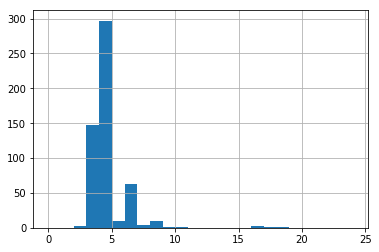

{}

In [16]:
import matplotlib.pyplot as plt

u.hist(bins=range(25))
plt.show()

course_group = {}
num_group = 0
drop_row = []
for uid in np.unique(courses.loc[:,'First Instructor UID'].values):
    courses_uid = courses.loc[courses.loc[:,'First Instructor UID'] == uid,:]
    if len(courses_uid) > 1:
        for idx1 in range(len(courses_uid)-1):
            for idx2 in range(idx1+1, len(courses_uid)):
                if courses_uid.iloc[idx1,3] == courses_uid.iloc[idx2,3] \
                and courses_uid.iloc[idx1,4] == courses_uid.iloc[idx2,4] \
                and courses_uid.iloc[idx1,8] == courses_uid.iloc[idx2,8] \
                and courses_uid.iloc[idx1,8] != 'TBA':
                    if num_group == 0:
                        course_group[num_group] = []
                        course_group[num_group].append(courses_uid.iloc[idx1,:].name)
                        course_group[num_group].append(courses_uid.iloc[idx2,:].name)
                        num_group += 1
                    else:
                        isExist = False
                        for num in range(num_group):
                            if idx1 in course_group[num] or idx2 in course_group[num]:
                                course_group[num].append(courses_uid.iloc[idx1,:].name)
                                course_group[num].append(courses_uid.iloc[idx2,:].name)
                                isExist = True
                        if not isExist:
                            course_group[num_group] = []
                            course_group[num_group].append(courses_uid.iloc[idx1,:].name)
                            course_group[num_group].append(courses_uid.iloc[idx2,:].name)
                            num_group += 1
#for num in range(num_group):
#    course_group[num] = np.unique(np.array(course_group[num]))

course_group

### Test before applying the code

In [ ]:
from datetime import time
timedelta(minutes=30*4)
dd = datetime(year=1981, month=8, day=31, hour=8) + timedelta(minutes=30*4)
dd.strftime("%I:%M%p")


for uid in np.unique(UIDs.values):
    I_uid_boolean = (UIDs == uid)
    I_uid = I.values[I_uid_boolean]
    I_uid_day_boolean = [True if 'M' in Ki[i] else False for i in I_uid]
    I_uid_day = I_uid[I_uid_day_boolean]
    if sum(I_uid_day_boolean) > 1:
        print(uid, sum([1 for i in I_uid_day]) )
type(UIDs[1])
np.unique(UIDs.values[UIDs.values!=''])
mod.NumConstrs
int(len(L)/u[2])
for m in range(slots_per_day):
    for n in range(6, slots_per_day-m):
        divider = True
        if m-n>=0 :
            divider = False
        for o in range(6,n):
            if n%o==0:
                divider = False
        if divider:
            L_1 = range(m,len(L))
            L_2 = [True if (l-m)%n == 0 else False for l in L_1 ]
            print(np.array(L_1)[L_2] ) 
             
courses.describe()